In [1]:
from math import pi
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import wavio
import IPython
from scipy.io.wavfile import write, read
import sys

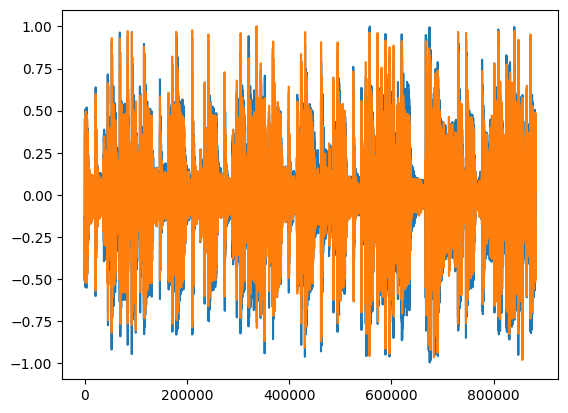

In [2]:
rate, file = read("Protection.wav")

fixed_data0 = file[:, 0]
fixed_data1 = file[:, 1]
data0 = fixed_data0.astype(np.float32, order='C') / 32767.0
data1 = fixed_data1.astype(np.float32, order='C') / 32767.0

start = 10
end = 30
data0 = data0[start * rate : end * rate]
data1 = data1[start * rate : end * rate]

plt.plot(data0)
plt.plot(data1)
plt.show()

In [3]:
class Biquad:
    def __init__(self, b0, b1, b2, a0, a1, a2):
        # Filter coefficients
        self.b0 = b0
        self.b1 = b1
        self.b2 = b2
        self.a0 = a0
        self.a1 = a1
        self.a2 = a2

        # State variables
        self.x1 = self.x2 = self.y1 = self.y2 = 0.0

    def process(self, x):
        # Direct Form II implementation
        w = x - self.a1 * self.x1 - self.a2 * self.x2
        y = self.b0 * w + self.b1 * self.x1 + self.b2 * self.x2

        # Update state variables
        self.x2 = self.x1
        self.x1 = w
        self.y2 = self.y1
        self.y1 = y

        return y

def Pan(L, R, factor):
    return L * factor, R * (1 - factor)

def decode(data0, data1):
    C = np.zeros(data0.size)
    S = np.zeros(data1.size)
    Panning = 0.5
    CB = np.array([0.5, 0.5])
    
    b = [6.1006178758069665e-05, 0.00012201235751613933, 6.1006178758069665e-05]
    a = [1.0, -1.9777864837767638, 0.9780305084917961]

    biquad = Biquad(b[0], b[1], b[2], a[0], a[1], a[2])
    
    for index, data in enumerate(zip(data0, data1)):
        L = data[0]
        R = data[1]

        VCA_L, VCA_R = Pan(L, R, Panning)

        C[index] = VCA_L + VCA_R
        S[index] = VCA_L - VCA_R

        FWR_L = np.abs(VCA_L)
        FWR_R = np.abs(VCA_R)
        
        E = FWR_L + FWR_R
        
        flag = np.float32(FWR_L * FWR_R > 0)
        Panning = biquad.process(flag * np.divide(FWR_R, E, out=np.zeros_like(FWR_R), where=E!=0) + (1 - flag) * Panning)
        
    return C, S

C, S = decode(data0, data1)
LS, _ = decode(data0, S)
RS, _ = decode(data1, S)

In [4]:
write("C.wav", rate, (C  * 32767.0).astype(np.int16))
write("S.wav", rate, (S  * 32767.0).astype(np.int16))
write("LS.wav", rate, (LS * 32767.0).astype(np.int16))
write("RS.wav", rate, (RS * 32767.0).astype(np.int16))

IPython.display.display(IPython.display.Audio("C.wav", rate=rate))
IPython.display.display(IPython.display.Audio("S.wav", rate=rate))
IPython.display.display(IPython.display.Audio("LS.wav", rate=rate))
IPython.display.display(IPython.display.Audio("RS.wav", rate=rate))